In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
from webweb import Web

In [2]:
# Define jane's information
jane_hpos = ['HP:0002066','HP:0020221','HP:0032792','HP:0001733','HP:0001824']
jane_hpo_common_names = ['Gait ataxia','Clonic seizures','Tonic seizures','Pancreatitis','Weight loss']
jane_genes = ['SSPO','NBEA']

In [3]:
def clear_ax(ax, top=False, bottom=False, left=False, right=False):
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    ax.yaxis.set_tick_params(width=0.0, labelsize=8)
    ax.xaxis.set_tick_params(width=0.0, labelsize=8)


In [4]:
# load the graphs
G = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
hpos = [x for x in G.nodes if 'HP:' in x]
genes = [x for x in G.nodes if 'HP:' not in x]
# HPO
H = G.subgraph(hpos)
# String
S = G.subgraph(genes)

In [5]:
print(len(G.nodes))
print(len(H.nodes))
print(len(S.nodes))
assert(len(H.nodes) + len(S.nodes) == len(G.nodes))

35699
16041
19658


['HP:0002066', 'HP:0001288', 'HP:0100022', 'HP:0012638', 'HP:0000707', 'HP:0000118', 'HP:0020221', 'HP:0020219', 'HP:0001250', 'HP:0012638', 'HP:0000707', 'HP:0000118', 'HP:0032792', 'HP:0020219', 'HP:0001250', 'HP:0012638', 'HP:0000707', 'HP:0000118', 'HP:0001733', 'HP:0012091', 'HP:0012093', 'HP:0000818', 'HP:0000118', 'HP:0001824', 'HP:0004325', 'HP:0004323', 'HP:0001507', 'HP:0000118']
28
18


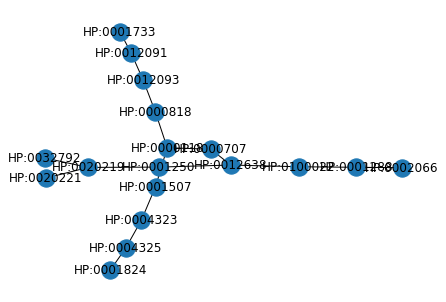

In [6]:
# create a graph of the sortest path from all HPOs to the root
h_nodes = []
for h in jane_hpos:
    path = nx.shortest_path(H,h,'HP:0000118')
    h_nodes = h_nodes + path
print(h_nodes)
print(len(h_nodes))
print(len(set(h_nodes)))
h = H.subgraph(h_nodes)
nx.draw(h, with_labels = True)

NBEA degree 733
['AGAP1', 'AGAP2', 'AGAP3', 'AGAP4', 'AGAP5', 'AGAP6', 'APPL1', 'APPL2', 'ARHGEF25', 'C14orf80', 'C16orf96', 'C7orf73', 'CCBE1', 'CCDC154', 'CDC42', 'CDC42EP4', 'CEP170B', 'CHPF', 'CNKSR1', 'CNKSR3', 'CRIP2', 'CYFIP1', 'DLGAP4', 'DPYSL2', 'DPYSL3', 'ENSG00000279058', 'EPB41L1', 'EXPH5', 'FAM114A1', 'FAM149A', 'FAM220A', 'FZD3', 'GIGYF1', 'GIPC1', 'GPR156', 'HOMER1', 'IP6K3', 'LRP12', 'LRP8', 'LRRC7', 'MXRA7', 'MYH10', 'NBEA', 'NHSL2', 'PHLDB1', 'RALB', 'RASAL2', 'RASD2', 'RBMS3', 'RHBDF1', 'RIN1', 'SDK2', 'SHANK1', 'SPTBN2', 'TSPAN9', 'UBALD1', 'WASF3', 'XPO4', 'ZNF233', 'ZNF564']


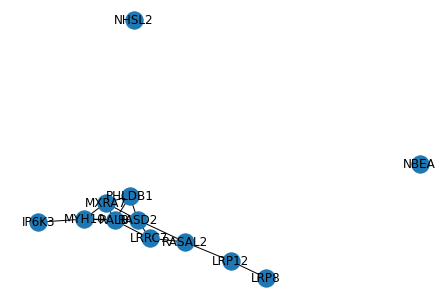

In [7]:
# create a graph of the neighbors of NBEA, SSPO is not in String

print('NBEA degree',len(list(S.neighbors('NBEA'))))

# get neighbors of NBEA from the community of interest
coms = BOCC.load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
com = [x for x in coms if str(x.name) == '84'][0]
print(com.get_genes())
genes_to_plot = ['NBEA']
index = com.get_genes().index('NBEA')
s = S.subgraph(com.get_genes()[index-6:index+6])
nx.draw(s, with_labels = True)

In [8]:
# load the original clusters
g_coms = BOCC.load_clusters('../Clusters/2021/greedy.2021.coms.txt')
w_coms = BOCC.load_clusters('../Clusters/2021/walktrap.2021.coms.txt')
i_coms = BOCC.load_clusters('../Clusters/2021/infomap.2021.coms.txt')
c_coms = BOCC.load_clusters('../Clusters/2021/cesna.2021.coms.txt')

In [9]:
# remove trival communities
def remove_trivial_coms(coms):
    keepers = []
    for c in coms:
        if len(c.members) > 2 and len(c.get_genes()) > 0 and len(c.get_genes()) != len(c.members):
            keepers.append(c)
    return keepers

print('# all clusters',sum([len(g_coms),len(w_coms),len(i_coms),len(c_coms),]))

g_coms = remove_trivial_coms(g_coms)
w_coms = remove_trivial_coms(w_coms)
i_coms = remove_trivial_coms(i_coms)
c_coms = remove_trivial_coms(c_coms)

print('# non-trivial clusters',sum([len(g_coms),len(w_coms),len(i_coms),len(c_coms)]))

# all clusters 27809
# non-trivial clusters 1970


0 greedy
1 walktrap
2 infomap
3 cesna


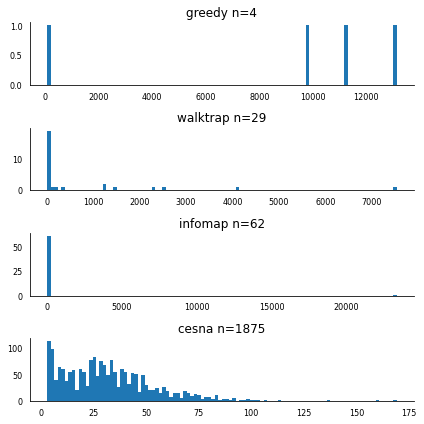

In [10]:
# plot size distribution of original coms
fig, axes = plt.subplots(4)
fig.set_size_inches(6, 6)

for i,n in enumerate(zip([g_coms,w_coms,i_coms,c_coms],['greedy','walktrap','infomap','cesna'])):
    print(i,n[1])
#     print(n[0])
    # plot size vs gene:HPO ratio
    # title n=# coms
    xs = [ len(c.members) for c in n[0]]

    ys = [ len(c.get_genes()) / (len(c.members) - len(c.get_genes())) if len(c.get_genes()) != len(c.members) else 1 for c in n[0]]

#     axes[i].scatter(xs, ys)
    axes[i].set_title('{algo} n={n}'.format(algo=n[1],n=str(len(n[0]))))
    axes[i].hist(xs,bins=100)
#     axes[i].set_yscale('log')
    clear_ax(axes[i],bottom=True, left=True)
plt.tight_layout()
plt.savefig('../Figures/cluster_2021_non_trivial_size_dist.png',dpi=300)
plt.show()


In [11]:
# do the same things as above but with the paris 2021 crosses
g_subcoms = BOCC.load_clusters('../SubComs/2021/paris.greedy.2021.coms.txt')
w_subcoms = BOCC.load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
i_subcoms = BOCC.load_clusters('../SubComs/2021/paris.infomap.2021.coms.txt')
c_subcoms = BOCC.load_clusters('../SubComs/2021/paris.cesna.2021.coms.txt')

print('# sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))
g_subcoms = remove_trivial_coms(g_subcoms)
w_subcoms = remove_trivial_coms(w_subcoms)
i_subcoms = remove_trivial_coms(i_subcoms)
c_subcoms = remove_trivial_coms(c_subcoms)
print('# non-trivial sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))

# sub clusters 32767
# non-trivial sub clusters 3696


0 greedy-paris
1 walktrap-paris
2 infomap-paris
3 cesna-paris


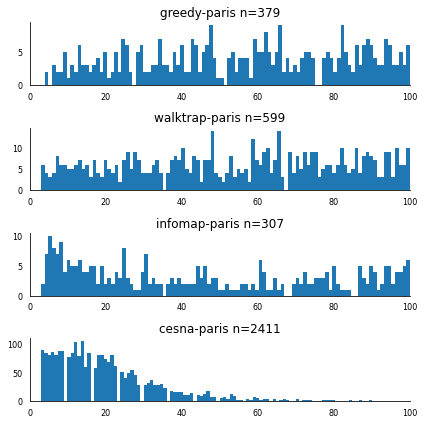

In [12]:
# plot size distribution of original coms
fig, axes = plt.subplots(4)
fig.set_size_inches(6, 6)

for i,n in enumerate(zip([g_subcoms,w_subcoms,i_subcoms,c_subcoms],['greedy-paris','walktrap-paris','infomap-paris','cesna-paris'])):
    print(i,n[1])
#     print(n[0])
    # plot size vs gene:HPO ratio
    # title n=# coms
    xs = [ len(c.members) for c in n[0]]

    ys = [ len(c.get_genes()) / (len(c.members) - len(c.get_genes())) if len(c.get_genes()) != len(c.members) else 1 for c in n[0]]

#     axes[i].scatter(xs, ys)
    axes[i].set_title('{algo} n={n}'.format(algo=n[1],n=str(len(n[0]))))
    axes[i].hist(xs,bins=100)
    axes[i].set_xlim(0,100)
#     axes[i].set_yscale('log')
    clear_ax(axes[i],bottom=True, left=True)
plt.tight_layout()
plt.savefig('../Figures/paris_subclusters_2021_non_trivial_size_dist.png',dpi=300)
plt.show()

### Snowball simulation results

In [13]:
# load rediscovery stats
g_snow = pd.read_csv('../SnowballResults/snowball.paris.greedy.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
w_snow = pd.read_csv('../SnowballResults/snowball.paris.walktrap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
i_snow = pd.read_csv('../SnowballResults/snowball.paris.infomap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
c_snow = pd.read_csv('../SnowballResults/snowball.paris.cesna.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
print(g_snow.shape)
print(w_snow.shape)
print(i_snow.shape)
print(c_snow.shape)

(182900, 5)
(80400, 5)
(385500, 5)
(2847100, 5)


0 (182900, 5) greedy
1 (80400, 5) walktrap
2 (385500, 5) infomap
3 (2847100, 5) cesna


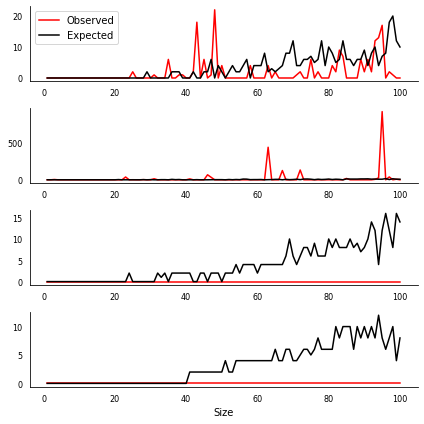

In [14]:
# plot size vs num rediscoveries for obversed & expected for each algo
fig, axes = plt.subplots(4)
fig.set_size_inches(6, 6)

for i,d in enumerate(zip([g_snow,w_snow,i_snow,c_snow],['greedy','walktrap','infomap','cesna'])):
    print(i,d[0].shape,d[1])
    # obsereved  = median of real values
    # expected =. median of snowball simulations
    plt_data = {'size':[],'observed':[],'expected':[]}
    # for this df get 
    plt_df = d[0].groupby('rep_and_com_size').median().reset_index()
    axes[i].plot(plt_df['rep_and_com_size'],plt_df['com_score'],color='red',label='Observed')
    axes[i].plot(plt_df['rep_and_com_size'],plt_df['replicate_score'],color='black',label='Expected')
    clear_ax(axes[i],bottom=True, left=True)
axes[-1].set_xlabel('Size')
axes[0].legend()
plt.tight_layout()
plt.savefig('../Figures/snowball_paris_2020_size_v_rediscoveries.png',dpi=300)
plt.show()

0 (182900, 5) greedy
Greater 0.1935483870967742
Zero 0.7670858392564243
Less 0.03936577364680153
1 (80400, 5) walktrap
Greater 0.11442786069651742
Zero 0.8718905472636815
Less 0.013681592039800995
2 (385500, 5) infomap
Greater 0.06511024643320364
Zero 0.9278858625162127
Less 0.007003891050583658
3 (2847100, 5) cesna
Greater 0.0829264866004004
Zero 0.9168627726458501
Less 0.00021074075374942925


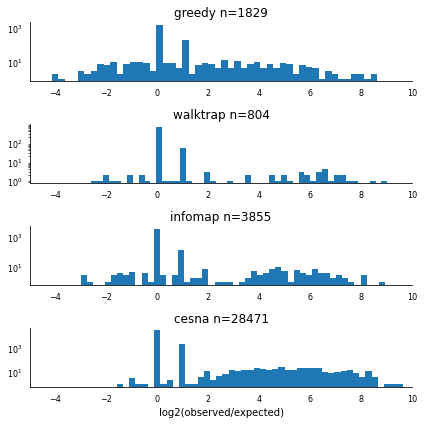

In [15]:
# plot observed vs expected (median simulation) for each cluster
fig, axes = plt.subplots(4)
fig.set_size_inches(6, 6)

def control_inf(x):
    if math.isinf(x):
#         print('Inf')
        return 1
    elif x == 0 or math.isnan(x):
#         print('Zero')
        return 0
    else:
#         if math.isnan(np.log2(x)):
#             print(x)
        return np.log2(x)

for i,d in enumerate(zip([g_snow,w_snow,i_snow,c_snow],['greedy','walktrap','infomap','cesna'])):
    print(i,d[0].shape,d[1])
    # for each com in this algo, plot its observed and expected values as one point
    plt_df = d[0].groupby('com_id').median().reset_index()
    plt_df['ratio'] = plt_df['com_score'] / plt_df['replicate_score']
    plt_df['log2_ratio'] = [ control_inf(x) for x in plt_df['ratio']]
    ratios = plt_df['log2_ratio']
    print('Greater',sum(plt_df['log2_ratio'] > 0) / len(ratios))
    print('Zero',sum(plt_df['log2_ratio'] == 0) / len(ratios))
    print('Less',sum(plt_df['log2_ratio'] < 0) / len(ratios))
    axes[i].set_yscale('log')
    axes[i].hist(ratios,bins=50)
    clear_ax(axes[i],bottom=True, left=True)
    axes[i].set_title('{algo} n={n}'.format(algo=d[1],n=str(len(d[0]['com_id'].unique()))))
    axes[i].set_xlim(-5,10)
axes[-1].set_xlabel('log2(observed/expected)')
# axes[0].legend()
plt.tight_layout()
plt.savefig('../Figures/snowball_paris_2020_expected_vs_obs.png',dpi=300)
plt.show()

Num real p=0.0000
Common 1351
FP 547
FN 547
% common 0.7118018967334035


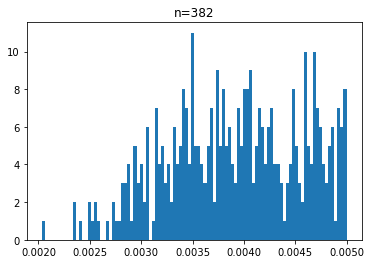

0.0020357621833682


In [16]:
# XGBoost true and false discovery rate
xg_df = pd.read_csv('../xgboost_results.csv')
xg_df_norm = pd.read_csv('../xgboost_res_norm_com_sizes_by_year.csv')
# print(xg_df.columns)
xg_df = xg_df[xg_df['year'] == 2020]
# print(xg_df.shape)
# create unique cluster IDs
xg_df['UID'] = xg_df['cluster_method'] + '-' + xg_df['subcluster_method']  + '-' + xg_df['year'].astype(str)  + '-' + xg_df['IDs'].astype(str)

# get the UIDs predicted to be p=0.000
# get the UIDs that are actually p=0.000

num_p0s = sum(xg_df['snowballing_pvalue'] == 0)
print('Num real p=0.0000',)

# get the 1898 most significant predicted clusters
xg_df = xg_df.sort_values('predicted_snowballing_pvalue')
pred_uids = list(xg_df.iloc[0:num_p0s,:]['UID'])
real_uids = list(xg_df[xg_df['snowballing_pvalue'] == 0]['UID'])
assert(len(pred_uids) == len(real_uids))

# how many are common
print('Common',len([i for i in pred_uids if i in real_uids]))
# how many are false positives
print('FP',len([i for i in pred_uids if i not in real_uids]))
# how many are false negatives
print('FN',len([i for i in real_uids if i not in pred_uids]))
print('% common',len([i for i in pred_uids if i in real_uids]) / num_p0s)
tmp_xs = [x for x in xg_df['predicted_snowballing_pvalue'] if x < 0.005]
plt.hist(tmp_xs, bins=100)
plt.title('n={}'.format(str(len(tmp_xs))))
plt.show()
print(min(xg_df['predicted_snowballing_pvalue']))


In [17]:
xg_df = pd.read_csv('../xgboost_results.csv')
xg_df_norm = pd.read_csv('../xgboost_res_norm_com_sizes_by_year.csv')
print(xg_df[xg_df['year'] == 2021])

Empty DataFrame
Columns: [cluster_origin, bocc_origin, cluster_method, subcluster_method, year, IDs, predicted_snowballing_pvalue, snowballing_pvalue, max_norm_cell_type_specificity, max_norm_disease_specificity, max_plof, mean_plof, median_plof, num_cell_type_string, num_disease_string, num_of_diseases, num_sig_go_enrichment_terms, std_plof, sum_plof, avg_embeddedness, avg_internal_degree, cluster_size, conductance, cut_ratio, edges_inside, expansion, gene_ratio, hub_dominance, internal_edge_density, newman_girvan_modularity, normalized_cut, significance, surprise, triangle_participation_ratio]
Index: []

[0 rows x 34 columns]


## Webweb Hair Ball

In [23]:
# make a list of unweighted edges
import random
random.seed(0)

print(len(G.nodes))
print(len(G.edges))

nodes = list(G.nodes)
idxs = random.sample(range(len(nodes)), 1000)
random_nodes = [nodes[i] for i in idxs]
g = G.subgraph(random_nodes)
edge_list = list(g.edges)
# add nodes by grabbing neighbors, not by random
print(len(edge_list))
print(len(edge_list[0]))

# instantiate webweb and show the result
Web(edge_list).show()




35699
6186885
22210
2
